# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import sys
from pylab import *
import os

sys.path.append(os.path.join(os.path.abspath(''), '..', 'modules'))
import plotting
import lorenz
import general
import importlib
import statlorenz
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import statsmodels.api as sm

# RcParams

In [2]:
from matplotlib import rcParams

rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
#rcParams['text.fontsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['axes.linewidth'] = 1

#rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Computer Modern Roman']
#rcParams['text.usetex'] = True

# Metadata

In [3]:
path_results          = os.path.join("..","..","results") 
path_plots            = os.path.join(path_results,"plots")


path_results_reliable = os.path.join(path_results,"Reliable")
path_results_over     = os.path.join(path_results,"Overconfident")
path_results_under    = os.path.join(path_results,"Underconfident")
path_results_incremental = os.path.join(path_results,"Incremental")

Nsample_reliable        = 100

quantiles = [0.0,0.25,0.75,1]
histbins = np.arange(0.05,2,0.1)
hist_xticks = [-1,-0.5,0,0.5,1,1.5,2.0,2.5,3]
hist_xticklabels = ["-1","","0","","1","","2","","3"]
hist_yticks = [0,20,40]
corr_yticks = [0,0.2,0.4,0.6,0.8]

# Make Directory

In [4]:
os.system("mkdir " + os.path.join(path_results,"plots"))

256

# Figure 1

## Load Data

In [5]:
sm_incremental_norm_ana = xr.load_dataset(os.path.join(path_results_incremental, "sm_incremental_norm_ana.nc"))
sm_under_norm_ana       = xr.load_dataset(os.path.join(path_results_under      , "sm_under_norm_ana.nc"))
sm_over_norm_ana        = xr.load_dataset(os.path.join(path_results_over       , "sm_over_norm_ana.nc"))
sm_reliable_norm_ana    = xr.load_dataset(os.path.join(path_results_reliable   , "sm_reliable_norm_ana.nc"))

In [6]:
pool_of_initial_conditions=xr.load_dataarray("../../data/InitialConditions/Initial_conditions.nc")

In [7]:
sm_reliable_raw_000=xr.load_dataset(os.path.join("..","..","data","PerfectModel_Reliable","sm","sm_000.nc"))

In [8]:
Nens=sm_reliable_raw_000.sizes["ens"]

In [9]:
nm_reliable_raw_000=xr.load_dataset(os.path.join("..","..","data","PerfectModel_Reliable","Experiment_000_analysis.nc"))

In [10]:
analysis = nm_reliable_raw_000["analysis"]

## Plotting

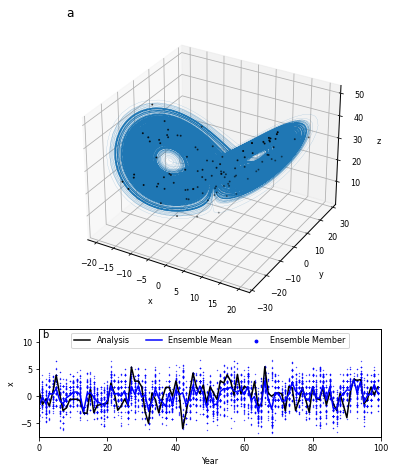

In [13]:

w=5.5
h= 0.6*9.25+1

fig  = plt.figure( figsize=(w,h))
#spec = gridspec.GridSpec(ncols=1, nrows=7, figure=fig)

ax2   = fig.add_axes([0.5/w,2.25/h,4.75/w,4/h],projection="3d")
ax3   = fig.add_axes([0.5/w,0.5/h,4.75/w,1.5/h])

#ax2 = fig.add_subplot(spec[0:5],projection='3d')
#ax3 = fig.add_subplot(spec[5:7])


ax2.plot(pool_of_initial_conditions.sel(dimension="x"),
         pool_of_initial_conditions.sel(dimension="y"),
         pool_of_initial_conditions.sel(dimension="z"), lw=0.1,label="Pool of Initial Conditions")
ax2.scatter(analysis.isel(time=0).sel(dimension="x"),
            analysis.isel(time=0).sel(dimension="y"),
            analysis.isel(time=0).sel(dimension="z"), 
        color="black",label="Reference starting points",s=1)

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("a",loc="left")


ax3.plot(sm_reliable_raw_000["analysis"].sel(dimension="x").sel({"leadtime in days": 12}),                 color="black", label="Analysis")
ax3.plot(sm_reliable_raw_000["hindcast"].sel(dimension="x").sel({"leadtime in days": 12}).mean(dim="ens"), color="blue" , label="Ensemble Mean")

ax3.scatter(sm_reliable_raw_000["hindcast"].time,sm_reliable_raw_000["hindcast"].sel(dimension="x").sel({"leadtime in days": 12}).isel(ens=0),     color="blue" , label="Ensemble Member",s=0.1)

for ens in range(1,Nens):
    ax3.scatter(sm_reliable_raw_000["hindcast"].time,sm_reliable_raw_000["hindcast"].sel(dimension="x").sel({"leadtime in days": 12}).sel(ens=ens), s=0.1, color="blue")
    
    
ax3.set_xlim(0,100)
ax3.set_xlabel("Year")
ax3.set_ylabel("x")
ax3.set_ylim(-7.5,12.5)
ax3.legend(ncol=3,loc="upper center",markerscale=9)
ax3.text(0.01, 0.99,'b', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax3.transAxes )

#ax3.set_title("b)",loc="left")

plt.savefig(os.path.join(path_plots,"Figure1.jpg"),dpi=1000)

# Figure 2

## Load Data

In [14]:
path_reliable_norm_scaife = os.path.join("..","..","results","scaife","sm_reliable_norm_scaife_12_x.nc")

In [15]:
sm_reliable_norm_ana_12_x    = xr.load_dataset(os.path.join(path_results_reliable, "sm_reliable_norm_ana.nc")).sel(dimension="x").sel({"leadtime in days":12})
reliable_min_distance_index  = xr.load_dataset(os.path.join(path_results_reliable, "sm_reliable_min_distance_index.nc"))["index"]
sm_reliable_norm_scaife_12_x = xr.load_dataset(os.path.join(path_results_reliable, "sm_reliable_norm_scaife.nc")).sel(dimension="x").sel({"leadtime in days": 12})

## Calculate Quantiles

In [16]:
sm_reliable_norm_scaife_12_x_quantiles = plotting.Calculate_Quantiles(sm_reliable_norm_scaife_12_x,dimension="permutation",quantiles=quantiles)

## Plot

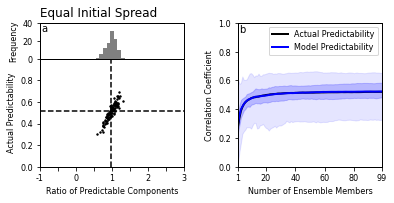

In [17]:
w=5.5
h=3
fig  = plt.figure(figsize=(w,h))

ax1   = fig.add_axes([0.5/w,2/h,2/w,0.5/h])
ax2   = fig.add_axes([0.5/w,0.5/h,2/w,1.5/h])
ax3   = fig.add_axes([3.25/w,0.5/h,2/w,2.0/h])


ax1.hist(sm_reliable_norm_ana_12_x["ratio_of_predictable_components_cor"].values.flatten(), bins= histbins, color="gray")
ax1.set_ylabel("Frequency")

ax1.set_xticks(hist_xticks)
ax1.set_yticks(hist_yticks)
#ax1.set_ylim(0,2.5)
ax1.set_xticklabels(hist_xticklabels)
ax1.set_title("Equal Initial Spread",loc="left")
plt.setp(ax1.get_xticklabels(), visible=False)

ax2.scatter(sm_reliable_norm_ana_12_x["ratio_of_predictable_components_cor"], 
            sm_reliable_norm_ana_12_x["actual_predictability"], s=2, color="black")

ax2.set_xticks(hist_xticks)
ax2.set_xticklabels(hist_xticklabels)
ax2.set_yticks(corr_yticks)
ax2.set_ylim(0,1)

ax2.set_xlabel("Ratio of Predictable Components")
ax2.set_ylabel("Actual Predictability")

ax2.axvline(sm_reliable_norm_ana_12_x.mean(dim="sample")["ratio_of_predictable_components_cor"], color="black",linestyle="--")
ax2.axhline(sm_reliable_norm_ana_12_x.mean(dim="sample")["actual_predictability"], color="black", linestyle="--")


ax3.plot(sm_reliable_norm_scaife_12_x.number_of_ensemble_members,
         sm_reliable_norm_scaife_12_x.sel(sample=reliable_min_distance_index).mean(dim="permutation")["actual_predictability"],
         linewidth=2,
         color="black",
         label="Actual Predictability")
ax3.plot(sm_reliable_norm_scaife_12_x.number_of_ensemble_members,
         sm_reliable_norm_scaife_12_x.sel(sample=reliable_min_distance_index).mean(dim="permutation")["model_predictability"],
         linewidth=2,
         color="blue",
         label="Model Predictability",)

############################## Plot Error Bars ##########################################################

quantile_data = sm_reliable_norm_scaife_12_x_quantiles.sel(sample=reliable_min_distance_index)


plotting.plot_error_bar(ax3,quantile_data,quantiles=quantiles)

ax3.set_xlim(1,99)
ax3.set_ylim(0,1)
ax3.set_xlabel("Number of Ensemble Members")
ax3.set_ylabel("Correlation Coefficient")
ax3.legend(loc="upper right")
ax3.set_xticks([1,20,40,60,80,99])

ax1.text(0.01, 0.99,'a', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax1.transAxes )
ax3.text(0.01, 0.99,'b', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax3.transAxes )


plt.savefig(os.path.join(path_plots,"Figure2.jpg"),dpi=1000)

# Figure 3

## Load Data

In [18]:
sm_under_norm_ana_12_x    = xr.load_dataset(os.path.join(path_results_under, "sm_under_norm_ana.nc")).sel(dimension="x").sel({"leadtime in days":12})
under_min_distance_index  = xr.load_dataset(os.path.join(path_results_under, "sm_under_min_distance_index.nc"))["index"]
sm_under_norm_scaife_12_x = xr.load_dataset(os.path.join(path_results_under, "sm_under_norm_scaife.nc")).sel(dimension="x").sel({"leadtime in days": 12})

In [19]:
sm_over_norm_ana_12_x    = xr.load_dataset(os.path.join(path_results_over, "sm_over_norm_ana.nc")).sel(dimension="x").sel({"leadtime in days":12})
over_min_distance_index  = xr.load_dataset(os.path.join(path_results_over, "sm_over_min_distance_index.nc"))["index"]
sm_over_norm_scaife_12_x = xr.load_dataset(os.path.join(path_results_over, "sm_over_norm_scaife.nc")).sel(dimension="x").sel({"leadtime in days": 12})

In [20]:
sm_incremental_norm_ana_12_x    = xr.load_dataset(os.path.join(path_results_incremental, "sm_incremental_norm_ana.nc")).sel(dimension="x").sel({"leadtime in days":12})

## Calculate Quantiles

In [21]:
sm_over_norm_scaife_12_x_quantiles  = plotting.Calculate_Quantiles(sm_over_norm_scaife_12_x,dimension="permutation",quantiles=quantiles)
sm_under_norm_scaife_12_x_quantiles = plotting.Calculate_Quantiles(sm_under_norm_scaife_12_x,dimension="permutation",quantiles=quantiles)

## Plot

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

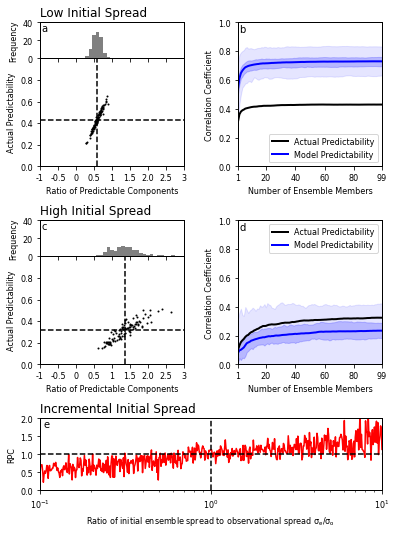

In [22]:
w=5.5
h=7.5

fig=plt.figure(figsize=(w, h))


ax_under_scatter   = fig.add_axes([0.5/w,2.25/h,2/w,1.5/h])
ax_under_hist      = fig.add_axes([0.5/w,3.75/h,2/w,0.5/h])
ax_under_scaife   = fig.add_axes([3.25/w,2.25/h,2/w,2/h])


ax_over_scatter  = fig.add_axes([0.5/w,5.00/h,2/w,1.5/h])
ax_over_hist     = fig.add_axes([0.5/w,6.5/h,2/w,0.5/h])
ax_over_scaife   = fig.add_axes([3.25/w,5.00/h,2/w,2/h])





ax_full_length=fig.add_axes([0.5/w,0.5/h,4.75/w,1/h])
##########################################################################################################################################################
# Plot Overconfident
##########################################################################################################################################################

ax_over_hist.hist(sm_over_norm_ana_12_x["ratio_of_predictable_components_cor"].values.flatten(), bins=np.arange(0.05,2,0.1),color="gray")
ax_over_hist.set_ylabel("Frequency")
ax_over_hist.set_xticks(hist_xticks)
ax_over_hist.set_xlim((hist_xticks[0],hist_xticks[-1]))
ax_over_hist.set_yticks(hist_yticks)
ax_over_hist.set_title("Low Initial Spread",loc="left")
plt.setp(ax_over_hist.get_xticklabels(), visible=False)
                 
            
        
ax_over_scatter.scatter(sm_over_norm_ana_12_x["ratio_of_predictable_components_cor"],
                        sm_over_norm_ana_12_x["actual_predictability"],s=1,color="black")

ax_over_scatter.set_xlim((hist_xticks[0],hist_xticks[-1]))
ax_over_scatter.set_xticks(hist_xticks)
ax_over_scatter.set_xticklabels(hist_xticks)
ax_over_scatter.set_yticks(corr_yticks)
ax_over_scatter.set_ylim(0,1)
                 
ax_over_scatter.set_xlabel("Ratio of Predictable Components")
ax_over_scatter.set_ylabel("Actual Predictability")
ax_over_scatter.axvline(sm_over_norm_ana_12_x["ratio_of_predictable_components_rpc"].mean(dim="sample"),
                        color="black",
                        linestyle="--")
ax_over_scatter.axhline(sm_over_norm_ana_12_x["actual_predictability"].mean(dim="sample"),
                        color="black",
                        linestyle="--")
#ax2.set_title("b)",loc="left")

ax_over_scaife.plot(sm_over_norm_scaife_12_x.number_of_ensemble_members,
                    sm_over_norm_scaife_12_x.sel(sample=over_min_distance_index).mean(dim="permutation")["actual_predictability"],
         linewidth=2,
         color="black",
         label="Actual Predictability")
ax_over_scaife.plot(sm_over_norm_scaife_12_x.number_of_ensemble_members,
                    sm_over_norm_scaife_12_x.sel(sample=over_min_distance_index).mean(dim="permutation")["model_predictability"],
         linewidth=2,
         color="blue",
         label="Model Predictability")


ax_over_scaife.set_xlim(1,99)
ax_over_scaife.set_ylim(0,1)
ax_over_scaife.set_xlabel("Number of Ensemble Members")
ax_over_scaife.set_ylabel("Correlation Coefficient")
ax_over_scaife.legend(loc="lower right")
ax_over_scaife.set_xticks([1,20,40,60,80,99])


quantile_data_over = sm_over_norm_scaife_12_x_quantiles.sel(sample=over_min_distance_index)


plotting.plot_error_bar(ax_over_scaife,quantile_data_over,quantiles=quantiles)


##########################################################################################################################################################
# Plot Underconfident
##########################################################################################################################################################

ax_under_hist.set_xlim((hist_xticks[0],hist_xticks[-1]))
ax_under_hist.hist(sm_under_norm_ana_12_x["ratio_of_predictable_components_cor"].values.flatten(),bins=np.arange(0.05,3,0.1),color="gray")
ax_under_hist.set_ylabel("Frequency")
ax_under_hist.set_title("High Initial Spread",loc="left")
ax_under_hist.set_yticks(hist_yticks)
ax_under_hist.set_xticks(hist_xticks)
plt.setp(ax_under_hist.get_xticklabels(), visible=False)
                 
ax_under_scatter.scatter(sm_under_norm_ana_12_x["ratio_of_predictable_components_cor"],
                         sm_under_norm_ana_12_x["actual_predictability"],s=1,color="black")

ax_under_scatter.set_xlim((hist_xticks[0],hist_xticks[-1]))
ax_under_scatter.set_xticks(hist_xticks)
ax_under_scatter.set_xticklabels(hist_xticks)
ax_under_scatter.set_ylim(0,1)
ax_under_scatter.set_yticks(corr_yticks)
                 
ax_under_scatter.set_xlabel("Ratio of Predictable Components")
ax_under_scatter.set_ylabel("Actual Predictability")
ax_under_scatter.axvline(sm_under_norm_ana_12_x["ratio_of_predictable_components_cor"].mean(dim="sample"),color="black",linestyle="--")
ax_under_scatter.axhline(sm_under_norm_ana_12_x["actual_predictability"].mean(dim="sample"),color="black",linestyle="--")


ax_under_scaife.plot(sm_under_norm_scaife_12_x.number_of_ensemble_members,
                     sm_under_norm_scaife_12_x.sel(sample=under_min_distance_index).mean(dim="permutation")["actual_predictability"],
         linewidth=2,
         color="black",
         label="Actual Predictability")
ax_under_scaife.plot(sm_under_norm_scaife_12_x.number_of_ensemble_members,
                     sm_under_norm_scaife_12_x.sel(sample=under_min_distance_index).mean(dim="permutation")["model_predictability"],
         linewidth=2,
         color="blue",
         label="Model Predictability")

    
ax_under_scaife.set_xlim(1,99)
ax_under_scaife.set_ylim(0,1)
ax_under_scaife.set_xlabel("Number of Ensemble Members")
ax_under_scaife.set_ylabel("Correlation Coefficient")
ax_under_scaife.legend(loc="upper right")
ax_under_scaife.set_xticks([1,20,40,60,80,99])


quantile_data_under = sm_under_norm_scaife_12_x_quantiles.sel(sample=under_min_distance_index)


plotting.plot_error_bar(ax_under_scaife,quantile_data_under,quantiles=quantiles)



##########################################################################################################################################################
# Plot Full
#########################################################################################################################################################


ax_full_length.set_title("Incremental Initial Spread",loc="left")
ax_full_length.set_xscale("log")


ax_full_length.plot(sm_incremental_norm_ana_12_x.std_ens_x/sm_incremental_norm_ana_12_x.std_obs_x,
                    sm_incremental_norm_ana_12_x["ratio_of_predictable_components_cor"]
                    ,color="red")

ax_full_length.set_xlim(0.1,10)
ax_full_length.set_ylim(0,2)
ax_full_length.set_ylabel("RPC")
ax_full_length.set_xlabel("Ratio of initial ensemble spread to observational spread " + r"$\sigma_e$/$\sigma_o$")

ax_full_length.axhline(1, color="black", linestyle = "--")
ax_full_length.axvline(1, color="black", linestyle = "--")

ax_over_hist.text(0.01, 0.99,'a', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax_over_hist.transAxes )
ax_over_scaife.text(0.01, 0.99,'b', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax_over_scaife.transAxes )

ax_under_hist.text(0.01, 0.99,'c', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax_under_hist.transAxes )
ax_under_scaife.text(0.01, 0.99,'d', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax_under_scaife.transAxes )

ax_full_length.text(0.01, 0.99,'e', fontsize=10,horizontalalignment='left', verticalalignment='top',transform = ax_full_length.transAxes )


plt.savefig(os.path.join(path_plots,"Figure3.jpg"),dpi=1000)

## Calculate Linear Regression Statistcs

In [23]:
sm_incremental_norm_ana_12_x_spread_ratio=sm_incremental_norm_ana_12_x["ratio_of_predictable_components_cor"].std_ens_x/sm_incremental_norm_ana_12_x["ratio_of_predictable_components_cor"].std_obs_x

In [24]:
model = sm.OLS(sm_incremental_norm_ana_12_x["ratio_of_predictable_components_cor"].values, sm.add_constant(np.log10(sm_incremental_norm_ana_12_x_spread_ratio.values)))

In [25]:
results = model.fit()

In [26]:
results.pvalues

array([0.00000000e+000, 3.47361903e-120])

In [27]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     985.1
Date:                Thu, 01 Oct 2020   Prob (F-statistic):          3.47e-120
Time:                        10:02:11   Log-Likelihood:                 132.82
No. Observations:                 501   AIC:                            -261.6
Df Residuals:                     499   BIC:                            -253.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9864      0.008    118.703      0.000       0.970       1.003
x1             0.4508      0.014     31.386      0.000       0.423       0.479
==============================================================================
Omnibus:                       11.381   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.387
Skew:                           0.057   Prob(JB):                     3.74e-05
Kurtosis:                       3.982   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
general.latex_export_variable(results.params[1], results.bse[1], os.path.join(path_results,"numbers","slope.txt"), significant_digits=2)

$0.450\ \pm \ 0.014$


# Figure 4

## Load Data

In [29]:
mm_over_norm_scaife     = xr.load_dataset(os.path.join(path_results,"Overconfident" , "mm_over_norm_scaife.nc")).sel(dimension="x").isel(sample=over_min_distance_index)
mm_under_norm_scaife    = xr.load_dataset(os.path.join(path_results,"Underconfident", "mm_under_norm_scaife.nc")).sel(dimension="x").isel(sample=under_min_distance_index)
mm_reliable_norm_scaife = xr.load_dataset(os.path.join(path_results,"Reliable"      , "mm_reliable_norm_scaife.nc")).sel(dimension="x").isel(sample=reliable_min_distance_index)

mm_incremental_norm_ana = xr.load_dataset(os.path.join(path_results,"Incremental","mm_incremental_norm_ana.nc"))

# Calculate Quantiles

In [30]:
mm_over_scaife_quantiles     = plotting.Calculate_Quantiles(mm_over_norm_scaife     , dimension="permutation")
mm_under_scaife_quantiles    = plotting.Calculate_Quantiles(mm_under_norm_scaife    , dimension="permutation")
mm_reliable_scaife_quantiles = plotting.Calculate_Quantiles(mm_reliable_norm_scaife , dimension="permutation")

## Plot

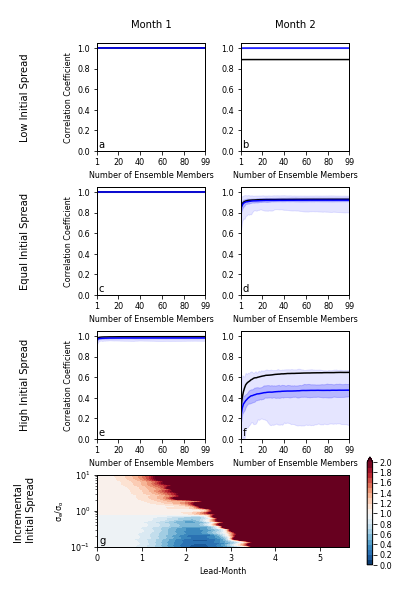

In [31]:
w=5.5
h=8
fig = plt.figure(figsize=(w,h))
ax_total=fig.add_axes([0,0,1,1],frameon=False)
#ax_over_nov=fid.add_axes()
#ax_reliable_nov=fig.add_axes()

ax_over_nov=fig.add_axes([1.25/w,6/h,1.5/w,1.5/h])
ax_over_dec=fig.add_axes([3.25/w,6/h,1.5/w,1.5/h])

ax_reliable_nov=fig.add_axes([1.25/w,4.0/h,1.5/w,1.5/h])
ax_reliable_dec=fig.add_axes([3.25/w,4.0/h,1.5/w,1.5/h])

ax_under_nov=fig.add_axes([1.25/w,2/h,1.5/w,1.5/h])
ax_under_dec=fig.add_axes([3.25/w,2/h,1.5/w,1.5/h])


ax_incremental = fig.add_axes([1.25/w,0.5/h,3.5/w,1/h])
#ax_over_nov.set_title("Month 1")
#ax_over_dec.set_title("Month 2")

ax_over_nov.set_xlabel("Number of Ensemble Members")
ax_over_nov.set_xticks([1,20,40,60,80,99])

ax_over_dec.set_xlabel("Number of Ensemble Members")#
ax_over_dec.set_xticks([1,20,40,60,80,99])

ax_reliable_nov.set_xlabel("Number of Ensemble Members")#
ax_reliable_nov.set_xticks([1,20,40,60,80,99])

ax_reliable_dec.set_xlabel("Number of Ensemble Members")#
ax_reliable_dec.set_xticks([1,20,40,60,80,99])

ax_under_nov.set_xlabel("Number of Ensemble Members")#
ax_under_nov.set_xticks([1,20,40,60,80,99])

ax_under_dec.set_xlabel("Number of Ensemble Members")#
ax_under_dec.set_xticks([1,20,40,60,80,99])

ax_over_nov.set_ylabel("Correlation Coefficient")
ax_reliable_nov.set_ylabel("Correlation Coefficient")
ax_under_nov.set_ylabel("Correlation Coefficient")


ax_total.set_xticks([])
ax_total.set_yticks([])
ax_total.text(0.25/w,1/h,"Incremental \n Initial Spread",rotation='vertical',horizontalalignment='center',verticalalignment="center")
ax_total.text(0.25/w,2.75/h,"High Initial Spread",rotation='vertical',horizontalalignment='center',verticalalignment="center")
ax_total.text(0.25/w,4.75/h,"Equal Initial Spread",rotation='vertical',horizontalalignment='center',verticalalignment="center")
ax_total.text(0.25/w,6.75/h,"Low Initial Spread",rotation='vertical',horizontalalignment='center',verticalalignment="center")

ax_total.text(2/w,7.75/h,"Month 1",horizontalalignment='center',verticalalignment="center")
ax_total.text(4/w,7.75/h,"Month 2",horizontalalignment='center',verticalalignment="center")

## Overconfident Scaife Plots

ax_over_nov.plot(mm_over_norm_scaife.number_of_ensemble_members,
                 mm_over_norm_scaife.sel({"leadtime in days":3}).mean(dim="permutation")["actual_predictability"], 
                 color="black",
                 label="Actual_Predictability")
ax_over_nov.plot(mm_over_norm_scaife.number_of_ensemble_members,
                 mm_over_norm_scaife.sel({"leadtime in days":3}).mean(dim="permutation")["model_predictability"],
                 color="blue",
                 label="Model Predictability")


ax_over_dec.plot(mm_over_norm_scaife.number_of_ensemble_members,
                 mm_over_norm_scaife.sel({"leadtime in days":6}).mean(dim="permutation")["actual_predictability"],
                 color="black",label="Actual_Predictability")
ax_over_dec.plot(mm_over_norm_scaife.number_of_ensemble_members,
                 mm_over_norm_scaife.sel({"leadtime in days":6}).mean(dim="permutation")["model_predictability"],
                 color="blue",
                 label="Model Predictability")

quantile_mm_over_nov = mm_over_scaife_quantiles.sel({"leadtime in days":3})
plotting.plot_error_bar(ax_over_nov, quantile_mm_over_nov)

quantile_mm_over_dec = mm_over_scaife_quantiles.sel({"leadtime in days":6})
plotting.plot_error_bar(ax_over_dec, quantile_mm_over_dec)

# Reliable Scaife Plots

ax_reliable_nov.plot(mm_reliable_norm_scaife.number_of_ensemble_members,
                 mm_reliable_norm_scaife.sel({"leadtime in days":3}).mean(dim="permutation")["actual_predictability"], 
                 color="black",
                 label="Actual_Predictability")
ax_reliable_nov.plot(mm_reliable_norm_scaife.number_of_ensemble_members,
                 mm_reliable_norm_scaife.sel({"leadtime in days":3}).mean(dim="permutation")["model_predictability"],
                 color="blue",
                 label="Model Predictability")


ax_reliable_dec.plot(mm_reliable_norm_scaife.number_of_ensemble_members,
                 mm_reliable_norm_scaife.sel({"leadtime in days":6}).mean(dim="permutation")["actual_predictability"],
                 color="black",label="Actual_Predictability")
ax_reliable_dec.plot(mm_reliable_norm_scaife.number_of_ensemble_members,
                 mm_reliable_norm_scaife.sel({"leadtime in days":6}).mean(dim="permutation")["model_predictability"],
                 color="blue",
                 label="Model Predictability")

quantile_mm_reliable_nov = mm_reliable_scaife_quantiles.sel({"leadtime in days":3})
plotting.plot_error_bar(ax_reliable_nov, quantile_mm_reliable_nov)

quantile_mm_reliable_dec = mm_reliable_scaife_quantiles.sel({"leadtime in days":6})
plotting.plot_error_bar(ax_reliable_dec, quantile_mm_reliable_dec)



# Underconfident Scaife Plots

ax_under_nov.plot(mm_under_norm_scaife.number_of_ensemble_members,
                 mm_under_norm_scaife.sel({"leadtime in days":3}).mean(dim="permutation")["actual_predictability"], 
                 color="black",
                 label="Actual_Predictability")
ax_under_nov.plot(mm_under_norm_scaife.number_of_ensemble_members,
                 mm_under_norm_scaife.sel({"leadtime in days":3}).mean(dim="permutation")["model_predictability"],
                 color="blue",
                 label="Model Predictability")


ax_under_dec.plot(mm_under_norm_scaife.number_of_ensemble_members,
                 mm_under_norm_scaife.sel({"leadtime in days":6}).mean(dim="permutation")["actual_predictability"],
                 color="black",label="Actual_Predictability")
ax_under_dec.plot(mm_under_norm_scaife.number_of_ensemble_members,
                 mm_under_norm_scaife.sel({"leadtime in days":6}).mean(dim="permutation")["model_predictability"],
                 color="blue",
                 label="Model Predictability")

quantile_mm_under_nov = mm_under_scaife_quantiles.sel({"leadtime in days":3})
plotting.plot_error_bar(ax_under_nov, quantile_mm_under_nov)

quantile_mm_under_dec = mm_under_scaife_quantiles.sel({"leadtime in days":6})
plotting.plot_error_bar(ax_under_dec, quantile_mm_under_dec)

ax_under_dec.set_ylim(0,1.05)
ax_under_nov.set_ylim(0,1.05)

ax_over_dec.set_ylim(0,1.05)
ax_over_nov.set_ylim(0,1.05)

ax_reliable_dec.set_ylim(0,1.05)
ax_reliable_nov.set_ylim(0,1.05)

ax_under_dec.set_xlim(1,99)
ax_under_nov.set_xlim(1,99)

ax_over_dec.set_xlim(1,99)
ax_over_nov.set_xlim(1,99)

ax_reliable_dec.set_xlim(1,99)
ax_reliable_nov.set_xlim(1,99)


ax_incremental.set_yscale("log")

#levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
#levels=[0,0.2,0.4,0.6,0.8,0.9,1.1,1.2,1.4,1.6,1.8,2.0,3.0]
levels=[0, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1 ,1.2, 1.3, 1.4, 1.6, 1.8, 2, 3]
levels=np.arange(0,2.01,0.1)
#cor_levels=[-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
colors=plotting.getcolorlist_all(levels,cbarname="RdBu_r",mincolor=0.05,maxcolor=0.95)
#cor_colors=plotting.getcolorlist_all(cor_levels,cbarname="RdBu",mincolor=0,maxcolor=1)

ax_incremental.set_xlabel("Lead-Month")
ax_incremental.set_ylabel(r"$\sigma_e/ \sigma_o$")

mm_incremental_rpc_gaussian = gaussian_filter(np.abs(mm_incremental_norm_ana.sel(dimension="x")["ratio_of_predictable_components_cor"]),
                                              [5,5])

#mm_incremental_rpc_gaussian = mm_incremental_norm_ana.sel(dimension="x")["ratio_of_predictable_components_rpc"]
mm_incremental_spread_error = mm_incremental_norm_ana.std_ens_x/mm_incremental_norm_ana.std_obs_x
mm_incremental_lead_time_in_months = mm_incremental_norm_ana["leadtime in days"]/3-1

plot = ax_incremental.contourf(mm_incremental_lead_time_in_months,
                           mm_incremental_spread_error,
                           mm_incremental_rpc_gaussian,
                   levels=levels, cmap="RdBu_r",extend="max")# cmap="RdBu_r")

ax_colorbar    = fig.add_axes([5/w,0.25/h,0.075/w,1.5/h])
cbar=plt.colorbar(plot, cax = ax_colorbar,ticks=np.arange(0,2.1,0.2))
#cbar.ax.set_xticklabels(["0","","0.2","","0.4","","0.6","","0.8","","1.0","","1.2","","1.4","","1.6","","1.8","","2"])
#cbar.ax.set_ticks([-1,-0.5,0,0.5,1,1.5,2,2.5,3])


ax_over_nov.text(0.01, 0.01,'a', fontsize=10,horizontalalignment='left', verticalalignment='bottom',transform = ax_over_nov.transAxes )
ax_over_dec.text(0.01, 0.01,'b', fontsize=10,horizontalalignment='left', verticalalignment='bottom',transform = ax_over_dec.transAxes )


ax_reliable_nov.text(0.01, 0.01,'c', fontsize=10,horizontalalignment='left', verticalalignment='bottom',transform = ax_reliable_nov.transAxes )
ax_reliable_dec.text(0.01, 0.01,'d', fontsize=10,horizontalalignment='left', verticalalignment='bottom',transform = ax_reliable_dec.transAxes )


ax_under_nov.text(0.01, 0.01,'e', fontsize=10,horizontalalignment='left', verticalalignment='bottom',transform = ax_under_nov.transAxes )
ax_under_dec.text(0.01, 0.01,'f', fontsize=10,horizontalalignment='left', verticalalignment='bottom',transform = ax_under_dec.transAxes )

ax_incremental.text(0.01, 0.01,'g', fontsize=10,horizontalalignment='left', verticalalignment='bottom',transform = ax_incremental.transAxes )

plt.savefig(os.path.join(path_plots,"Figure4.jpg"),dpi=1000)